# Effect of randomized response
We compare counts with and without randomized response to see if it impacts bias

In [19]:
import random

def randomizedResponse(truth):
    if (random.random() < 0.5):
        return truth
    else:
        return random.random() < 0.5


In [20]:
import sqlite3

conn = sqlite3.connect("medical.db")
cur = conn.cursor()

In [80]:
import pandas as pd

dfFPreg = pd.read_sql_query("""
SELECT DISTINCT COUNT(p.patient) AS count FROM conditions c
JOIN patients p ON c.patient = p.patient
WHERE description = 'Coronary Heart Disease' AND p.gender = 'F'
""", conn)

dfMPreg = pd.read_sql_query("""
SELECT DISTINCT COUNT(p.patient) AS count FROM conditions c
JOIN patients p ON c.patient = p.patient
WHERE description = 'Coronary Heart Disease' AND p.gender = 'M'
""", conn)

dfF = pd.read_sql_query("""
SELECT DISTINCT COUNT(patient) AS count FROM patients
WHERE gender = 'F'
""", conn)

dfM = pd.read_sql_query("""
SELECT DISTINCT COUNT(patient) AS count FROM patients
WHERE gender = 'M'
""", conn)

dfF.at[0, 'count']
dfM.at[0, 'count']
dfFPreg.at[0, 'count']
dfMPreg.at[0, 'count']

pregF = dfFPreg.at[0, 'count']
notPregF = dfF.at[0, 'count'] - pregF
pregM = dfMPreg.at[0, 'count']
notPregM = dfM.at[0, 'count'] - pregM

randF = 0

for x in range(pregF):
    if randomizedResponse(True):
        randF = randF + 1
for x in range(notPregF):
    if randomizedResponse(False):
        randF = randF + 1

print(pregF, randF)

randM = 0

for x in range(pregM):
    if randomizedResponse(True):
        randM = randM + 1
for x in range(notPregM):
    if randomizedResponse(False):
        randM = randM + 1

print(pregM, randM)

23 190
75 224


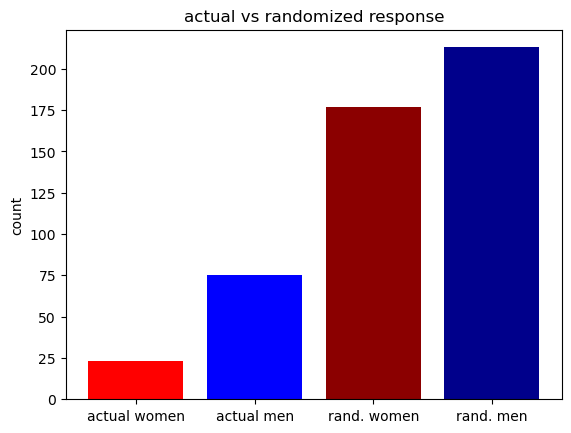

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['actual women', 'actual men', 'rand. women', 'rand. men']
counts = [pregF, pregM, randF, randM]
bar_colors = ['red', 'blue', 'darkred', 'darkblue']

ax.bar(fruits, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('actual vs randomized response')

plt.show()

Actually there are three times as many men with this heart disease but after randomized response this difference becomes totally diluted. This is why we must subtract how many we expect to answer fake yes and mulitply by 2

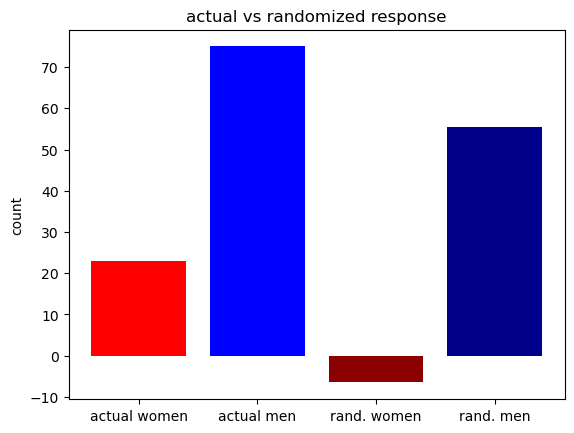

In [28]:
womenFakeYesses = dfF.at[0, 'count'] / 4
menFakeYesses = dfM.at[0, 'count'] / 4

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

fruits = ['actual women', 'actual men', 'rand. women', 'rand. men']
counts = [pregF, pregM, (randF - womenFakeYesses) * 2, (randM - menFakeYesses) * 2]
bar_colors = ['red', 'blue', 'darkred', 'darkblue']

ax.bar(fruits, counts, color=bar_colors)

ax.set_ylabel('count')
ax.set_title('actual vs randomized response')

plt.show()

After subtracting the fake yesses the bias is intact

In [242]:
femalePreg = pd.read_sql_query("""
SELECT DISTINCT p.patient AS count FROM conditions c
JOIN patients p ON c.patient = p.patient
WHERE description = 'Coronary Heart Disease' AND p.gender = 'F'
""", conn)

malePreg = pd.read_sql_query("""
SELECT DISTINCT p.patient AS count FROM conditions c
JOIN patients p ON c.patient = p.patient
WHERE description = 'Coronary Heart Disease' AND p.gender = 'M'
""", conn)

print("her")
metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'count': {
                    'name': 'count',
                    'type': 'string'
                }
            }
        }
    }
}

from snsql import Privacy
privacy = Privacy(epsilon=0.5, delta=0.01)

def makearray(index):
    men = []
    women = []
    for n in range(index):
        menReader = snsql.from_connection(malePreg, privacy=privacy, metadata=metadata)
        menDescription, menResult = menReader.execute('SELECT  COUNT(*) as amount FROM MyTable')

        womenReader = snsql.from_connection(femalePreg, privacy=privacy, metadata=metadata)
        womenDescription, womenResult = womenReader.execute('SELECT COUNT(*) as amount FROM MyTable')
        men.append(menResult[0])
        women.append(womenResult[0])
    return men, women

her


C:\Users\krist\anaconda3\lib\site-packages\snsql\sql\private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\snsql\sql\private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider

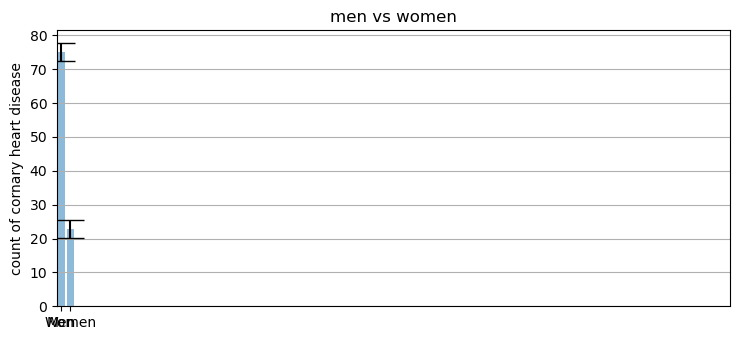

In [243]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dpMen, dpWomen = makearray(100)
dpmenMean = np.mean(dpMen)
dpWomenMean = np.mean(dpWomen)

stdmen = np.std(dpMen)
stdwomen = np.std(dpWomen)

columns = ['Men', 'Women']
x_pos = np.arange(len(columns))
CTEs = [dpmenMean,dpWomenMean]
error = [stdmen, stdwomen]

fig, ax = plt.subplots()


ax.bar(x_pos, CTEs, yerr=error,align='center', alpha=0.5, ecolor='black', capsize=10)

ax.set_xticks(CTEs)
ax.set_xticks(x_pos)
ax.set_xticklabels(columns)
ax.set_ylabel('count of cornary heart disease')
ax.set_title('men vs women')
ax.yaxis.grid(True)


plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

C:\Users\krist\anaconda3\lib\site-packages\snsql\sql\private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(
C:\Users\krist\anaconda3\lib\site-packages\snsql\sql\private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider

her


"\nmenReader = snsql.from_connection(malePreg, privacy=privacy, metadata=metadata)\nmenResult = menReader.execute('SELECT  COUNT(*) as amount FROM MyTable')\nwomenReader = snsql.from_connection(femalePreg, privacy=privacy, metadata=metadata)\nwomenResult = womenReader.execute('SELECT COUNT(*) as amount FROM MyTable')\n"